[View in Colaboratory](https://colab.research.google.com/github/DongminWu/MLpractice/blob/master/deep_siamese_one_shot_learning.ipynb)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from scipy.stats import norm

from scipy.signal import triang

from sklearn.utils import shuffle

# Data Generating

In [0]:
num_of_each_type = 40
num_of_weekend = 13
day_length = 1440

In [0]:
def gaussian_pdf(mu,  sigma, length):
  '''
  mu: mean of the gaussian distribution
  sigma: variance of the gaussian distribution
  
  length: the length of the sequence
  '''
  
  raw_ = np.linspace(-5, 5, length)
  ret = 1/(sigma * np.sqrt(2 * np.pi)) * \
      np.exp( - (raw_ - mu)**2 / (2 * sigma**2))
  return ret

                
  

# Triangle wave

def triangle_pdf(mid, width, length):

  raw_ = np.linspace(-5, 5, length)

  l_mask = mid  - float(width)/2
  l_empty = np.where(raw_ < l_mask)[0]

  ret_l = [0]*len(l_empty)

  r_mask = mid + float(width)/2
  r_empty = np.where(raw_ > r_mask)[0]
  ret_r = [0]*len(r_empty)

  number_mid = length - len(l_empty) - len(r_empty)
  ret_m = triang(number_mid)

  ret = np.concatenate([ret_l, ret_m, ret_r])
  
  return ret


def random_pdf(prob, max, length):
  raw = [0] * length
  
  for i,each in enumerate(raw):
    r = np.random.random()
    if r < prob:
      raw[i] = np.random.uniform(-max, max)

  return np.array(raw)


def generate_binary(distribution):
  return np.array([np.random.choice( np.array([0,1]),p=[1-p,p]) for p in distribution])

## Train set

In [0]:
# 4 sensors

g1_set = [generate_binary(gaussian_pdf(0,1,day_length)) for i in range(num_of_each_type)]
g2_set = [generate_binary(gaussian_pdf(1,1.3,day_length)) for i in range(num_of_each_type)]
t1_set = [generate_binary(triangle_pdf(0,5,day_length)) for i in range(num_of_each_type)]
t2_set = [generate_binary(triangle_pdf(-1,4,day_length)) for i in range(num_of_each_type)]
empty1_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]
empty2_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]


In [6]:
g_set = np.concatenate([g1_set, g2_set])
np.random.shuffle(g_set)
g_pair_set = g_set.reshape([-1,2,1440])

t_set = np.concatenate([t1_set, t2_set])
np.random.shuffle(t_set)
t_pair_set = t_set.reshape([-1,2,1440])

empty_set = np.concatenate([empty1_set, empty2_set])
np.random.shuffle(empty_set)
empty_pair_set = empty_set.reshape([-1,2,1440])

trainX_neighbors = np.concatenate([g_pair_set, t_pair_set, empty_pair_set])
trainY_neighbors = np.ones([trainX_neighbors.shape[0],1])

print("trainX_neighbors", trainX_neighbors.shape)
print("trainY_neighbors", trainY_neighbors.shape)



trainX_neighbors (93, 2, 1440)
trainY_neighbors (93, 1)


In [7]:

trainX_no_neighbors = []
for i in range(trainX_neighbors.shape[0]):
  first_set = np.random.choice([t_set, g_set, empty_set])
  second_set = np.random.choice([t_set, g_set, empty_set])
  first_idx = np.random.choice(first_set.shape[0]-1)
  second_idx = np.random.choice(second_set.shape[0]-1)
  sample = np.array([first_set[first_idx], second_set[second_idx]] )
  trainX_no_neighbors.append(sample)

trainX_no_neighbors = np.stack(trainX_no_neighbors)
trainY_no_neighbors = np.zeros([trainX_no_neighbors.shape[0],1])
print("trainX_no_neighbors", trainX_no_neighbors.shape)
print("trainY_no_neighbors", trainY_no_neighbors.shape)

trainX_no_neighbors (93, 2, 1440)
trainY_no_neighbors (93, 1)


In [8]:
trainX = np.concatenate([trainX_neighbors, trainX_no_neighbors])
trainY = np.concatenate([trainY_neighbors, trainY_no_neighbors])
trainX, trainY = shuffle(trainX, trainY)
trainX = trainX[:,:,:,None]
print("trainX", trainX.shape)
print("trainY", trainY.shape)

trainX (186, 2, 1440, 1)
trainY (186, 1)


## Test Set

The difference is the mean and variance of each waveform


In [100]:
# 4 sensors

g1_set = [generate_binary(gaussian_pdf(0,1,day_length)) for i in range(num_of_each_type)]
g2_set = [generate_binary(gaussian_pdf(0,1.3,day_length)) for i in range(num_of_each_type)]
t1_set = [generate_binary(triangle_pdf(0,5,day_length)) for i in range(num_of_each_type)]
t2_set = [generate_binary(triangle_pdf(0,4,day_length)) for i in range(num_of_each_type)]
empty1_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]
empty2_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]

g_set = np.concatenate([g1_set, g2_set])
np.random.shuffle(g_set)
g_pair_set = g_set.reshape([-1,2,1440])

t_set = np.concatenate([t1_set, t2_set])
np.random.shuffle(t_set)
t_pair_set = t_set.reshape([-1,2,1440])

empty_set = np.concatenate([empty1_set, empty2_set])
np.random.shuffle(empty_set)
empty_pair_set = empty_set.reshape([-1,2,1440])

testX_neighbors = np.concatenate([g_pair_set, t_pair_set, empty_pair_set])
testY_neighbors = np.ones([testX_neighbors.shape[0],1])

print("testX_neighbors", testX_neighbors.shape)
print("testY_neighbors", testY_neighbors.shape)

testX_no_neighbors = []
for i in range(testX_neighbors.shape[0]):
  first_set = np.random.choice([t_set, g_set, empty_set])
  second_set = np.random.choice([t_set, g_set, empty_set])
  first_idx = np.random.choice(first_set.shape[0]-1)
  second_idx = np.random.choice(second_set.shape[0]-1)
  sample = np.array([first_set[first_idx], second_set[second_idx]] )
  testX_no_neighbors.append(sample)

testX_no_neighbors = np.stack(testX_no_neighbors)
testY_no_neighbors = np.zeros([testX_no_neighbors.shape[0],1])
print("testX_no_neighbors", testX_no_neighbors.shape)
print("testY_no_neighbors", testY_no_neighbors.shape)


testX = np.concatenate([testX_neighbors, testX_no_neighbors])
testY = np.concatenate([testY_neighbors, testY_no_neighbors])
testX, testY = shuffle(testX, testY)
testX = testX[:,:,:,None]
print("testX", testX.shape)
print("testY", testY.shape)

testX_neighbors (93, 2, 1440)
testY_neighbors (93, 1)
testX_no_neighbors (93, 2, 1440)
testY_no_neighbors (93, 1)
testX (186, 2, 1440, 1)
testY (186, 1)


# model building



## LSTM model


![替代文字](https://cloud.githubusercontent.com/assets/9861437/20479454/405a1aea-b004-11e6-8a27-7bb05cf0a002.png)

In [0]:
from keras import Sequential
from keras import Model
from keras.layers import LSTM, Bidirectional, Input, Dense, Lambda, merge
from keras import backend as K

In [0]:
dim_lstm_layer = 64
dim_dense = 32

In [0]:
input1 = Input(shape=(None, 1), name = 'input_layer1')
input2 = Input(shape=(None, 1), name = 'input_layer2')

bi_lstm1_1 = Bidirectional(LSTM(dim_lstm_layer, return_sequences=True), merge_mode='ave', name="LSTM_layer1_1")(input1)
bi_lstm1_2 = Bidirectional(LSTM(dim_lstm_layer, return_sequences=True), merge_mode='ave', name="LSTM_layer1_2")(input2)

bi_lstm2_1 = Bidirectional(LSTM(dim_lstm_layer), merge_mode='ave', name="LSTM_layer2_1")(bi_lstm1_1)
bi_lstm2_2 = Bidirectional(LSTM(dim_lstm_layer), merge_mode='ave', name="LSTM_layer2_2")(bi_lstm1_2)


flat1 = Dense(dim_dense, name="flat1")(bi_lstm2_1)
flat2 = Dense(dim_dense, name="flat2")(bi_lstm2_2)


L1_distance = lambda x: K.abs(x[0]-x[1])

both = Lambda(L1_distance, output_shape=lambda x: x[0])([flat1, flat2])
# both = merge([flat1, flat2], mode=L1_distance, output_shape=lambda x: x[0])

prediction = Dense(1,activation='sigmoid')(both)


model = Model([input1, input2], prediction)

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer1 (InputLayer)       (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_layer2 (InputLayer)       (None, None, 1)      0                                            
__________________________________________________________________________________________________
LSTM_layer1_1 (Bidirectional)   (None, None, 64)     33792       input_layer1[0][0]               
__________________________________________________________________________________________________
LSTM_layer1_2 (Bidirectional)   (None, None, 64)     33792       input_layer2[0][0]               
__________________________________________________________________________________________________
LSTM_layer

In [0]:
model.compile("adam", loss="binary_crossentropy")

In [15]:
for i in range(30):
  print("=========> epoch:", i)
#   model.fit([trainX[:,0,:,:],trainX[:,1,:,:] ], trainY, batch_size = 64, validation_data=([testX[:,0,:,:],testX[:,1,:,:]], testY))
  

=========> epoch: 0
=========> epoch: 1
=========> epoch: 2
=========> epoch: 3
=========> epoch: 4
=========> epoch: 5
=========> epoch: 6
=========> epoch: 7
=========> epoch: 8
=========> epoch: 9
=========> epoch: 10
=========> epoch: 11
=========> epoch: 12
=========> epoch: 13
=========> epoch: 14
=========> epoch: 15
=========> epoch: 16
=========> epoch: 17
=========> epoch: 18
=========> epoch: 19
=========> epoch: 20
=========> epoch: 21
=========> epoch: 22
=========> epoch: 23
=========> epoch: 24
=========> epoch: 25
=========> epoch: 26
=========> epoch: 27
=========> epoch: 28
=========> epoch: 29


## 1D-CNN

In [0]:


dropout_rate = 0.2
regularizer_coef = 0.01
rolling_window = 30

In [209]:
trX = np.zeros(trainX.shape)
teX = np.zeros(testX.shape)

print("trainX shape:", trainX.shape )

for s in range(trainX.shape[0]):
  for i in range(trainX.shape[1]):
    tmp = pd.DataFrame(trainX[s,i,:,0]).rolling(rolling_window, win_type='hamming').mean().fillna(0)
    trX[s,i,:,:]=tmp.as_matrix()
 

print("testX shape:", testX.shape )

for s in range(testX.shape[0]):
  for i in range(testX.shape[1]):
    tmp = pd.DataFrame(testX[s,i,:,0]).rolling(rolling_window, win_type='hamming').mean().fillna(0)
    teX[s,i,:,:]=tmp.as_matrix()
  

trainX shape: (186, 2, 1440, 1)
testX shape: (186, 2, 1440, 1)


In [0]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [103]:


input_l = Input(shape=(day_length, 1), name = 'input_layer_l')
input_r = Input(shape=(day_length, 1), name = 'input_layer_r')

conv_1_l = Conv1D(64, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_1_l")(input_l)
conv_1_r = Conv1D(64, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_1_r")(input_r)

pool_1_l = MaxPooling1D(pool_size=2, name="pool_1_l")(conv_1_l)
pool_1_r= MaxPooling1D(pool_size=2, name="pool_1_r")(conv_1_r)

drop_1_l = Dropout(dropout_rate)(pool_1_l)
drop_1_r = Dropout(dropout_rate)(pool_1_r)


conv_2_l = Conv1D(32, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_3_l")(drop_1_l)
conv_2_r = Conv1D(32, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_3_r")(drop_1_r)

pool_2_l = MaxPooling1D(pool_size=2, name="pool_4_l")(conv_2_l)
pool_2_r= MaxPooling1D(pool_size=2, name="pool_4_r")(conv_2_r)

drop_2_l = Dropout(dropout_rate)(pool_2_l)
drop_2_r = Dropout(dropout_rate)(pool_2_r)

conv_3_l = Conv1D(16, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_5_l")(drop_2_l)
conv_3_r = Conv1D(16, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_5_r")(drop_2_r)

pool_3_l = MaxPooling1D(pool_size=2, name="pool_6_l")(conv_3_l)
pool_3_r= MaxPooling1D(pool_size=2, name="pool_6_r")(conv_3_r)

drop_3_l = Dropout(dropout_rate)(pool_3_l)
drop_3_r = Dropout(dropout_rate)(pool_3_r)


flat_l = Flatten(name="flat_l")(drop_3_l)
flat_r = Flatten(name="flat_r")(drop_3_r)

dense_7_l = Dense(dim_dense, name="dense_7_l")(flat_l)
dense_7_r = Dense(dim_dense, name="dense_7_r")(flat_r)



L1_distance = lambda x: K.abs(x[0]-x[1])

both = Lambda(L1_distance, output_shape=lambda x: x[0])([dense_7_l, dense_7_r])
# both = merge([flat1, flat2], mode=L1_distance, output_shape=lambda x: x[0])

prediction = Dense(1,activation='sigmoid', name="output")(both)


model = Model([input_l, input_r], prediction)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_l (InputLayer)      (None, 1440, 1)      0                                            
__________________________________________________________________________________________________
input_layer_r (InputLayer)      (None, 1440, 1)      0                                            
__________________________________________________________________________________________________
conv_1_l (Conv1D)               (None, 1436, 64)     384         input_layer_l[0][0]              
__________________________________________________________________________________________________
conv_1_r (Conv1D)               (None, 1436, 64)     384         input_layer_r[0][0]              
__________________________________________________________________________________________________
pool_1_l (

In [0]:
model.compile("adam", loss="binary_crossentropy", metrics=['acc'])

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=20, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
model.reset_states()

In [211]:
# for i in range(30):
#   print("=========> epoch:", i)
history = model.fit([trX[:,0,:,:],trX[:,1,:,:] ], trainY, 
                    epochs=50, 
                    callbacks = callbacks_list,
                    batch_size = 2, 
                    validation_data=([teX[:,0,:,:],teX[:,1,:,:]], testY))
  

Train on 186 samples, validate on 186 samples
Epoch 1/50
186/186 [==============================] - 5s 26ms/step - loss: 0.7346 - acc: 0.7151 - val_loss: 0.5041 - val_acc: 0.8226
Epoch 2/50
186/186 [==============================] - 2s 12ms/step - loss: 0.5556 - acc: 0.8011 - val_loss: 0.5461 - val_acc: 0.7957
Epoch 3/50
186/186 [==============================] - 2s 12ms/step - loss: 0.5813 - acc: 0.8011 - val_loss: 0.4809 - val_acc: 0.8172
Epoch 4/50
186/186 [==============================] - 2s 12ms/step - loss: 0.5133 - acc: 0.8172 - val_loss: 0.4840 - val_acc: 0.8226
Epoch 5/50
186/186 [==============================] - 2s 12ms/step - loss: 0.4163 - acc: 0.8602 - val_loss: 0.4713 - val_acc: 0.7849
Epoch 6/50
186/186 [==============================] - 2s 12ms/step - loss: 0.4916 - acc: 0.8226 - val_loss: 0.5221 - val_acc: 0.7796
Epoch 7/50
 56/186 [========>.....................] - ETA: 1s - loss: 0.5767 - acc: 0.7321

186/186 [==============================] - 2s 12ms/step - loss: 0.4820 - acc: 0.8118 - val_loss: 0.6701 - val_acc: 0.7151
Epoch 8/50
186/186 [==============================] - 2s 12ms/step - loss: 0.4620 - acc: 0.8333 - val_loss: 0.5342 - val_acc: 0.7097
Epoch 9/50
186/186 [==============================] - 2s 12ms/step - loss: 0.4373 - acc: 0.8602 - val_loss: 0.4714 - val_acc: 0.7688
Epoch 10/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3956 - acc: 0.8710 - val_loss: 0.4202 - val_acc: 0.8333
Epoch 11/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3892 - acc: 0.8548 - val_loss: 0.4464 - val_acc: 0.8172
Epoch 12/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3844 - acc: 0.8602 - val_loss: 0.4365 - val_acc: 0.8065
Epoch 13/50
140/186 [=====================>........] - ETA: 0s - loss: 0.3286 - acc: 0.8857

186/186 [==============================] - 2s 12ms/step - loss: 0.3509 - acc: 0.8656 - val_loss: 0.4178 - val_acc: 0.8172
Epoch 14/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3542 - acc: 0.8495 - val_loss: 0.5118 - val_acc: 0.7312
Epoch 15/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3572 - acc: 0.8817 - val_loss: 0.3953 - val_acc: 0.8441
Epoch 16/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2998 - acc: 0.8978 - val_loss: 0.5598 - val_acc: 0.8280
Epoch 17/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2963 - acc: 0.8978 - val_loss: 0.4208 - val_acc: 0.8495
Epoch 18/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3591 - acc: 0.8710 - val_loss: 0.5366 - val_acc: 0.7796
Epoch 19/50
140/186 [=====================>........] - ETA: 0s - loss: 0.2974 - acc: 0.9143

186/186 [==============================] - 2s 12ms/step - loss: 0.3415 - acc: 0.8871 - val_loss: 0.4069 - val_acc: 0.8495
Epoch 20/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2924 - acc: 0.8925 - val_loss: 0.6319 - val_acc: 0.7312
Epoch 21/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2454 - acc: 0.9140 - val_loss: 0.4370 - val_acc: 0.8441
Epoch 22/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3434 - acc: 0.8602 - val_loss: 0.4843 - val_acc: 0.7957
Epoch 23/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2515 - acc: 0.9247 - val_loss: 0.6259 - val_acc: 0.6774
Epoch 24/50
186/186 [==============================] - 2s 12ms/step - loss: 0.5791 - acc: 0.8441 - val_loss: 0.9579 - val_acc: 0.6344
Epoch 25/50
140/186 [=====================>........] - ETA: 0s - loss: 0.3579 - acc: 0.8857

186/186 [==============================] - 2s 12ms/step - loss: 0.4487 - acc: 0.8710 - val_loss: 0.4444 - val_acc: 0.8387
Epoch 26/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2413 - acc: 0.9301 - val_loss: 0.6315 - val_acc: 0.7527
Epoch 27/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2793 - acc: 0.9140 - val_loss: 0.4843 - val_acc: 0.8226
Epoch 28/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2138 - acc: 0.9355 - val_loss: 0.4733 - val_acc: 0.8065
Epoch 29/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2445 - acc: 0.9409 - val_loss: 0.5083 - val_acc: 0.8387
Epoch 30/50
186/186 [==============================] - 2s 12ms/step - loss: 0.3396 - acc: 0.9086 - val_loss: 0.5215 - val_acc: 0.8118
Epoch 31/50
140/186 [=====================>........] - ETA: 0s - loss: 0.3044 - acc: 0.8929

186/186 [==============================] - 2s 12ms/step - loss: 0.2913 - acc: 0.8978 - val_loss: 0.4675 - val_acc: 0.8172
Epoch 32/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2768 - acc: 0.9355 - val_loss: 0.5414 - val_acc: 0.7903
Epoch 33/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2199 - acc: 0.9409 - val_loss: 0.5921 - val_acc: 0.7796
Epoch 34/50
186/186 [==============================] - 2s 12ms/step - loss: 0.1856 - acc: 0.9247 - val_loss: 0.5779 - val_acc: 0.7581
Epoch 35/50
186/186 [==============================] - 2s 12ms/step - loss: 0.2011 - acc: 0.9462 - val_loss: 0.5437 - val_acc: 0.8172
Epoch 36/50
186/186 [==============================] - 2s 12ms/step - loss: 0.1752 - acc: 0.9570 - val_loss: 0.5163 - val_acc: 0.8333
Epoch 37/50
140/186 [=====================>........] - ETA: 0s - loss: 0.1412 - acc: 0.9786

186/186 [==============================] - 2s 12ms/step - loss: 0.1560 - acc: 0.9624 - val_loss: 0.5822 - val_acc: 0.8226
Epoch 00037: early stopping


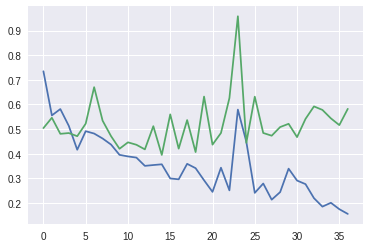

In [212]:
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="test_loss")




In [111]:
model.evaluate(x = [testX[:,0,:,:],testX[:,1,:,:]], y = testY)

186/186 [==============================] - 0s 406us/step


[0.7133773712701695, 0.7473118253933486]

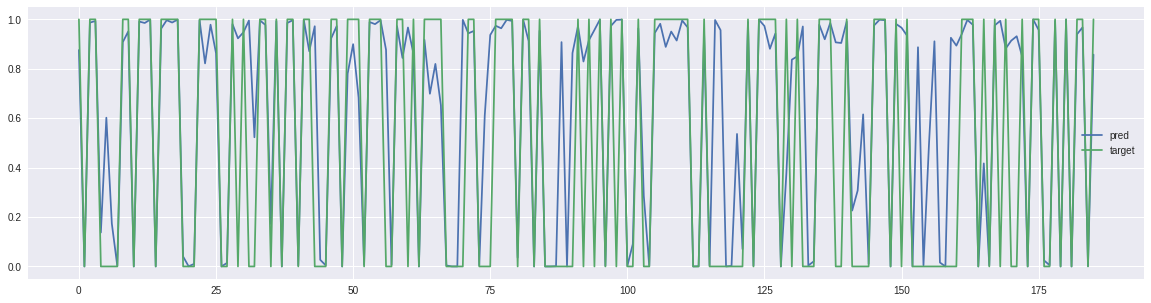

In [213]:
preds = model.predict([teX[:,0,:,:],teX[:,1,:,:]])
plt.figure(figsize=(20,5))
plt.plot(preds, label = "pred")
plt.plot(testY, label = 'target')
plt.legend()

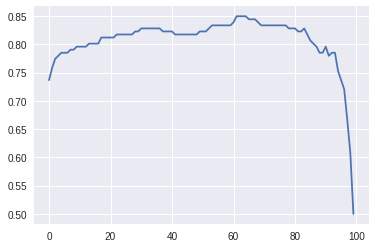

In [214]:
acc = []

for i in range(100):
  thres = (i+1)/100
  new_pred = preds.copy()
  new_pred[new_pred<thres] = 0
  new_pred[new_pred>=thres] = 1

  err = (new_pred != testY).sum()
  acc.append((len(testY)-err)/len(testY))

plt.plot(acc)

In [215]:
np.max(acc)

0.8494623655913979

In [216]:
np.argmax(acc)

61

In [0]:
thres = 0.62

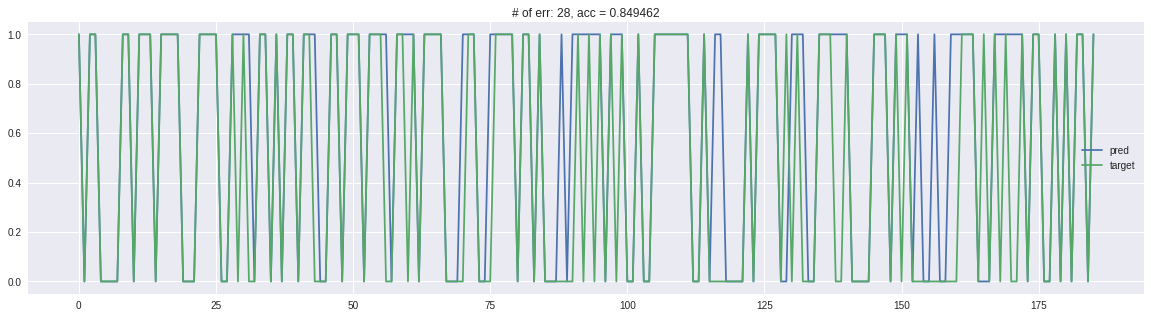

In [218]:
new_pred = preds.copy()
new_pred[new_pred<thres] = 0
new_pred[new_pred>=thres] = 1

err = (new_pred != testY).sum()

plt.figure(figsize=(20,5))
plt.plot(new_pred, label = "pred")
plt.plot(testY, label = 'target')
plt.title("# of err: %d, acc = %f" % (err, (len(testY)-err)/len(testY)))
plt.legend()


In [140]:
np.where(testY==0)[0]

array([  1,   4,   5,   6,   7,  10,  14,  19,  20,  21,  26,  27,  29,
        31,  32,  35,  37,  40,  43,  44,  45,  48,  52,  56,  57,  60,
        62,  67,  68,  69,  70,  73,  74,  75,  80,  83,  85,  86,  87,
        88,  89,  90,  92,  94,  96,  98, 100, 101, 103, 104, 112, 113,
       115, 116, 117, 118, 119, 120, 121, 123, 128, 130, 132, 133, 134,
       138, 139, 141, 142, 143, 144, 148, 150, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 164, 166, 168, 170, 171, 173, 176, 177, 179,
       181, 184])

In [0]:
num_sample = 122

Text(0.5,1,'pred: 0.635324')

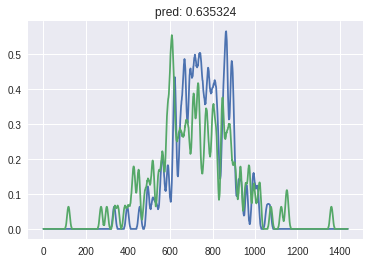

In [230]:
pred = model.predict([teX[num_sample,1,:,:][None,:,:],teX[num_sample,0,:,:][None,:,:]])

plt.plot(teX[num_sample,0,:,0])
plt.plot(teX[num_sample,1,:,0])
plt.title("pred: %f" % pred)